In [21]:
# --- Designing a function to create a match dashboard for a specific Statsbomb match id ---

# Imports
import math
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from statsbombpy import sb
from mplsoccer import VerticalPitch
from matplotlib.lines import Line2D
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'


# 
def create_match_dashboard(match_id, team1_color, team2_color, match_info=None, show_team_badges=True,
                           team1_image=None, team2_image=None):

    def get_match_metadata(target_id):
        # Get all available competitions
        comps = sb.competitions()
        
        # Iterate through every competition and season
        for _, row in comps.iterrows():
            try:
                # Check the matches for this specific comp/season
                matches = sb.matches(competition_id=row['competition_id'], season_id=row['season_id'])
                
                # If our match_id is in this list, we've found our desired data
                if target_id in matches['match_id'].values:
                    match_info = matches[matches['match_id'] == target_id].iloc[0]
                    return matches, match_info
            except:
                continue
                
        return None, None

    # Automatically find the matches_df and metadata
    if match_info is None:
        matches_df, match_info = get_match_metadata(match_id)
        
        # Only check matches_df if we actually performed the search
        if matches_df is None:
            print(f"Match ID {match_id} not found in available StatsBomb data.")
            return None

    # Extract the variables used to input manually
    competition_name = match_info['competition']
    competition_stage = match_info['competition_stage']
    match_date = match_info['match_date']
    team1_name = match_info['home_team']
    team2_name = match_info['away_team']
    
    # getting Statsbomb data from the desired match sorted in numerical and chronological order
    df = sb.events(match_id = match_id).sort_values(by=['index'])

    # Splitting the data set into the main match and penalty shootout to not confuse data in the seperate game states
    non_pen_df = df[df.period < 5]
    pen_df = df[df.period == 5]

    # checking if the match had a penalty shootout
    has_shootout = len(pen_df) > 0

     # Splitting the data set to seperate the events by both teams
    team1_df = non_pen_df[non_pen_df.team == team1_name]
    team2_df = non_pen_df[non_pen_df.team == team2_name]

    # Defining global variables/constants
    TEAM1_COLOR = team1_color
    TEAM2_COLOR = team2_color

    TEAM1_ID = non_pen_df[non_pen_df.team == team1_name]['team_id'].iloc[0]
    TEAM2_ID = non_pen_df[non_pen_df.team == team2_name]['team_id'].iloc[0]

    TEAM1_GOALS = len(non_pen_df[(non_pen_df.team == team1_name) & (non_pen_df.shot_outcome == 'Goal')])
    TEAM1_OG = len(non_pen_df[(non_pen_df.team == team2_name) & (non_pen_df.type == 'Own Goal Against')])
    TEAM1_SCORE = TEAM1_GOALS + TEAM1_OG
    
    # Goals scored by Team 2 (Shots + Own Goals by Team 1)
    TEAM2_GOALS = len(non_pen_df[(non_pen_df.team == team2_name) & (non_pen_df.shot_outcome == 'Goal')])
    TEAM2_OG = len(non_pen_df[(non_pen_df.team == team1_name) & (non_pen_df.type == 'Own Goal Against')])
    TEAM2_SCORE = TEAM2_GOALS + TEAM2_OG

    # function to create the shotmap for each team
    def create_shotmap(team, ax):
        pitch = VerticalPitch(pitch_type='statsbomb', half=True)
        pitch.draw(ax=ax)
        
        # Filter for shots only
        shots = team[team['type'] == 'Shot'].copy()

        # Making sure each team had at least one shot
        if not shots.empty:

            # Split location into x and y
            shots[['x', 'y']] = shots['location'].apply(pd.Series)
        
            # Draw the shotmap
            for _, shot in shots.iterrows():
                # Logic for coloring:
                # 1. Goal -> Green
                # 2. Saved (On Target but no goal) -> Red
                # 3. Everything else (Off Target, Blocked, etc.) -> White
                if shot['shot_outcome'] == 'Goal':
                    color = 'green'
                elif shot['shot_outcome'] == 'Saved':
                    color = 'red'
                else:
                    color = 'white'
                
                pitch.scatter(
                    x=shot['x'], 
                    y=shot['y'], 
                    ax=ax, 
                    s=500 * shot['shot_statsbomb_xg'], 
                    color=color, 
                    edgecolors='black', 
                    alpha=0.7,
                    zorder=2
                )
    
            # Create Legend Handles
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Goal',
                       markerfacecolor='green', markeredgecolor='black', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Saved',
                       markerfacecolor='red', markeredgecolor='black', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Miss/Blocked',
                       markerfacecolor='white', markeredgecolor='black', markersize=10),
            ]
            
            # Size handles (xG Scale)
            # We use sqrt because markersize in Line2D is diameter, while 's' in scatter is area
            for xg_val in [0.1, 0.5]:
                size = np.sqrt(500 * xg_val)
                legend_elements.append(
                    Line2D([0], [0], marker='o', color='w', label=f'{xg_val} xG',
                           markerfacecolor='gray', markeredgecolor='black', markersize=size)
                )
            
            # Adding the legend to the axis
            ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.2),
                      ncol=3, fontsize=8, frameon=False, handletextpad=0.1)

    
    # function to create the pass network for each team
    def create_passnetwork(team, ax):
        # Sort the dataframe and save it (assign back to team)
        team = team.copy()
        team["newsecond"] = 60 * team["minute"] + team["second"]
        team = team.sort_values(by=['newsecond'])

        # Split location only for rows that have it to avoid errors
        mask_loc = team['location'].notna()
        team.loc[mask_loc, ['x', 'y']] = team.loc[mask_loc, 'location'].apply(pd.Series).values
        
        tactics = team[~team['tactics'].isnull()][['tactics', 'team']]
    
        all_jersey_numbers = []
        for y in tactics.to_dict(orient='records'):
            all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
        
        if not all_jersey_numbers:
            return # Exit if no tactics data found
            
        jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
        
        # identify the passer and then the recipient
        team['passer'] = team['player_id']
        team['recipient'] = team['passer'].shift(-1)
        
        # filter for only passes and then successful passes
        passes_df = team.loc[(team['type']=="Pass")].copy()
        passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
        completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
        
        # find time of the team's first substitution
        sub_df = team.loc[(team['type'] == "Substitution")]
        
        if not sub_df.empty:
            first_sub = sub_df["newsecond"].min()
            if first_sub <= (60 * 45):
                first_sub = 60 * 45
        else:
            first_sub = 999999 
        
        completions = completions.loc[completions['newsecond'] < first_sub]
        
        # Find Average Locations
        average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
        average_locs_and_count.columns = ['x', 'y', 'count']
        
        # find number of passes
        passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
        passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
        
        passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
        passes_between = passes_between.merge(
            average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
        )
        
        passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
        pitch = VerticalPitch(pitch_type='statsbomb')
        pitch.draw(ax=ax)
        
        # Plot arrows
        for index, row in passes_between.iterrows():
            dist_delta = 1.2
            x, y, end_x, end_y = row['x'], row['y'], row['x_end'], row['y_end']
            dist = math.hypot(end_x - x, end_y - y)
            angle = math.atan2(end_y-y, end_x-x)
            upd_x = x + (dist - dist_delta) * math.cos(angle)
            upd_y = y + (dist - dist_delta) * math.sin(angle)
            
            ax.annotate(
                '', xy=(upd_y, upd_x), xytext=(y, x), zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color='black', alpha=.85)
            )
        
        # Plot nodes
        pitch.scatter(
            average_locs_and_count.x, average_locs_and_count.y, s=500,
            color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
        )
        
        # Safe jersey number lookup
        for index, row in average_locs_and_count.iterrows():
            player_id = row.name
            # Filter jersey numbers for this specific player
            matching_jersey = jersey_numbers[jersey_numbers['player_id'] == player_id]['jersey_number']
            
            # If the player is found, use their number; otherwise, use a placeholder
            if not matching_jersey.empty:
                label = str(int(matching_jersey.values[0]))
            else:
                label = "?" 

            pitch.annotate(
                label,
                xy=(row.x, row.y),
                c='#132743',
                va='center',
                ha='center',
                size=10,
                fontweight='bold',
                ax=ax
            )
            
    # function to calculate time of possession for both teams
    def calculate_possession_time(df, team1_name, team2_name):
        # 1. Create a total seconds column for easy math
        df['total_seconds'] = df['minute'] * 60 + df['second']
    
        # 2. Sort chronologically
        df = df.sort_values(['period', 'timestamp', 'index'])
        
        # 3. Calculate time difference between this event and the NEXT one
        # This represents the "active time" assigned to the current possession team
        df['time_delta'] = df['total_seconds'].shift(-1) - df['total_seconds']
        
        # 4. Clean up period transitions (e.g., time between 45:00 and 45:00 of next half)
        # We set deltas to 0 if the next event is in a different period
        df.loc[df['period'] != df['period'].shift(-1), 'time_delta'] = 0
        
        # 5. Sum the time_delta based on the 'possession_team' column
        # StatsBomb identifies who 'owns' the ball during every event
        possession_sums = df.groupby('possession_team')['time_delta'].sum()
        
        # 6. Extract totals and calculate percentage
        t1_time = possession_sums.get(team1_name, 0)
        t2_time = possession_sums.get(team2_name, 0)
        
        total_time = t1_time + t2_time
        
        if total_time > 0:
            t1_percent = round((t1_time / total_time) * 100)
            t2_percent = 100 - t1_percent
        else:
            t1_percent, t2_percent = 50, 50
            
        return t1_percent, t2_percent

        # function to create the summary statistics table for the match
    def create_table(team1, team2):
        # Drop rows where the pass_outcome is Unknown
        team1 = team1[team1['pass_outcome'] != 'Unknown']
        team2 = team2[team2['pass_outcome'] != 'Unknown']

        # calculating time of possession using the above function
        t1_pos, t2_pos = calculate_possession_time(non_pen_df, team1_name, team2_name)
        
        # Create a table with the data
        # We first need to calculate the statistics for each team:
        # - goals
        # - xG
        # - shots
        # - shots on target
        # - passes
        # - pass completion %
    
        # Create a dictionary to store the stats
        stats = {
            'goals': {'team1': TEAM1_SCORE, 'team2': TEAM2_SCORE},
            'xG': {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
            'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
            'shots_on_target': {
                'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
                'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
            },
            'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
            'pass_completion': {
                'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
                'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)
            }
        }
        
        # store as a dataframe
        stats_df = pd.DataFrame(stats).T
    
        column_labels = ['', '', '']
        table_vals = [
            [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
            [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
            [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
            [f"{t1_pos}%", 'Possession (Time %)', f"{t2_pos}%"],
            [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
            [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
        ]
        
        return column_labels, table_vals

    # function to create the xG flow chart for the match
    def create_xg_flow_chart(df, ax):
        # Preparing Shot Data for the lines
        shots = df[df['type'] == 'Shot'].sort_values(by="index").copy()
        shots['cumulative_xG'] = shots.groupby('team_id')['shot_statsbomb_xg'].cumsum()

        # Plotting the lines for each team
        for team in df['team_id'].unique():
            team_shots = shots[shots['team_id'] == team]
            color = TEAM1_COLOR if team == TEAM1_ID else TEAM2_COLOR
            
            # Add a 0 xG row at the start
            start_row = pd.DataFrame({
                'team_id': team, 'minute': 0, 'cumulative_xG': 0
            }, index=[0])
            team_shots = pd.concat([start_row, team_shots])
            
            ax.plot(
                team_shots['minute'], 
                team_shots['cumulative_xG'], 
                drawstyle='steps-post',
                c=color,
                linewidth=2,
                zorder=2
            )

            # Plotting Goals (Filled Green)
            team_goals = team_shots[team_shots['shot_outcome'] == 'Goal']
            for _, goal in team_goals.iterrows():
                ax.scatter(goal['minute'], goal['cumulative_xG'], 
                           c='green', edgecolor='black', s=100, zorder=5)
                # Name next to the dot (offset slightly)
                ax.text(goal['minute'] + 1.5, goal['cumulative_xG'], goal['player'], 
                        fontsize=8, va='center', fontweight='bold', fontfamily='monospace')
                
            # Helper function to find xG at a specific minute for non-shot events
            def get_xg_at_minute(m):
                prev = team_shots[team_shots['minute'] <= m]
                return prev['cumulative_xG'].iloc[-1] if not prev.empty else 0
    
            # Cards (Yellow and Red)
            card_cols = ['foul_committed_card', 'bad_behaviour_card']
            available_cols = [c for c in card_cols if c in df.columns]
            
            if available_cols:
                cards = df[(df['team_id'] == team) & (df['type'].isin(['Foul Committed', 'Bad Behaviour']))].copy()
                # Combine card columns
                cards['card_type'] = cards[available_cols[0]] if len(available_cols) == 1 else cards[available_cols[0]].fillna(cards[available_cols[1]])
                
                for _, card in cards[cards['card_type'].notna()].iterrows():
                    curr_xg = get_xg_at_minute(card['minute'])
                    card_color = 'yellow' if 'Yellow' in card['card_type'] else 'red'
                    
    
                    ax.scatter(card['minute'], curr_xg, marker='s', s=60, 
                               facecolor=card_color, alpha=0.5, edgecolor='black', linewidth=1, zorder=6)
    
            # Substitutions
            subs = df[(df['team_id'] == team) & (df['type'] == 'Substitution')]
            for _, sub in subs.iterrows():
                curr_xg = get_xg_at_minute(sub['minute'])
                # Plot a Blue Triangle (marker='^')
                ax.scatter(sub['minute'], curr_xg, marker='^', s=70, 
                           facecolor='blue', alpha=0.5, edgecolor='white', linewidth=1, zorder=6)
                
        # Styling and Legend
        ax.set_xticks([0, 15, 30, 45, 60, 75, 90, 105, 120])
        ax.set_xticklabels(['0\'', '15\'', '30\'', '45\'', '60\'', '75\'', '90\'', '105\'', '120\''])
        
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Goal', markerfacecolor='green', markersize=10),
            Line2D([0], [0], marker='s', color='w', label='Yellow Card', markerfacecolor='yellow', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Red Card', markerfacecolor='red', markersize=8),
            Line2D([0], [0], marker='^', color='w', label='Sub', markerfacecolor='blue', markersize=8)
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.45), 
                  ncol=4, fontsize=9, frameon=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Function to create a penalty shootout summary
    def create_penalty_shootout_chart(pen_df, ax):
        # Getting just the shots in the shootout
        pen_shots = pen_df[pen_df['type'] == 'Shot']
        
        # Sort chronologically and determine order
        pen_shots = pen_shots.sort_values(by='index')
        first_team = pen_shots.iloc[0]['team']
        second_team = team2_name if first_team == team1_name else team1_name
        
        # Calculate rounds per team
        pen_shots['round'] = pen_shots.groupby('team').cumcount() + 1
        max_rounds = pen_shots['round'].max()
        
        # Plot outcomes
        y_map = {first_team: 1, second_team: 0}
        for _, row in pen_shots.iterrows():
            if row['shot_outcome'] == 'Goal': color = 'green'
            elif row['shot_outcome'] == 'Saved': color = 'red'
            else: color = 'white'
            ax.scatter(row['round'], y_map[row['team']], color=color, 
                       edgecolors='black', s=350, zorder=3)
            
        # Labels and formatting
        ax.text(0, 1, first_team, ha='right', va='center', fontsize=12, 
                fontweight='bold', fontfamily='monospace')
        ax.text(0, 0, second_team, ha='right', va='center', fontsize=12, 
                fontweight='bold', fontfamily='monospace')

        # 5. Legend 
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Goal', 
                   markerfacecolor='green', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Saved', 
                   markerfacecolor='red', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='No Goal', 
                   markerfacecolor='white', markeredgecolor='black', markersize=8)
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.6, 0.9), 
                  ncol=3, fontsize=9, frameon=False, handletextpad=0.1)
        
        # Win Text
        t1_pens = len(pen_shots[(pen_shots.team == team1_name) & (pen_shots.shot_outcome == 'Goal')])
        t2_pens = len(pen_shots[(pen_shots.team == team2_name) & (pen_shots.shot_outcome == 'Goal')])
        pen_winner = team1_name if t1_pens > t2_pens else team2_name
        result_str = f" {pen_winner} wins in a Penalty Shootout {t1_pens}-{t2_pens}!"
        
        # Center coordinate is (1 + max_rounds) / 2
        ax.text((1 + max_rounds) / 2, -1.3, result_str, ha='center', fontsize=18, 
                fontweight='bold', fontfamily='monospace',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.6'))

        ax.set_xlim(-3, max_rounds + 1)
        ax.set_ylim(-2.0, 2.3)
        ax.axis('off')

    # setting up the match dashboard figure

    fig_height = 16 if has_shootout else 12
    fig = plt.figure(figsize=(15, fig_height))

    # Base coordinates that always stay within 0.0 to 1.0
    # We use a lower 'y' starting point for the bottom elements if there is a shootout
    bottom_row_y = 0.2
    xg_flow_y = 0.3
    middle_row_y = 0.40
    table_y = 0.3
    header_y = 0.9

    # Shift everything up slightly if there's no shootout to fill the 12-inch frame
    if not has_shootout:
        bottom_row_y = 0.10
        xg_flow_y = 0.10
        middle_row_y = 0.3
        table_y = 0.25
        header_y = 0.85
    
    # Team 1 Logo (Conditional)
    if show_team_badges:
        ax1 = fig.add_axes([.15, header_y - 0.02, .1, .15])
        team1_img = Image.open(team1_image)
        ax1.imshow(team1_img)
        ax1.axis('off')
    
    # Match, teams, event, date, and score
    ax2 = fig.add_axes([.45, header_y, .3, .1])
    
    # event, stage and date
    # Ensure stage is a string and handle potential NaNs
    stage_text = str(competition_stage) if pd.notna(competition_stage) else ""
    ax2.text(.5, .8, f'{competition_name} - {stage_text}\n{match_date}', fontsize=12, ha='center',
             fontdict={'family': 'monospace'})
    
    # Team 1 highlighted text
    team_1_text = ax2.text(.47, .4, team1_name, fontsize=24, ha='right', 
                           fontdict={'family': 'monospace'})
    team_1_text.set_bbox(dict(facecolor=TEAM1_COLOR, alpha=.5, edgecolor=TEAM1_COLOR, 
                              boxstyle='round'))

    # Team 2 highlighted text
    team_2_text = ax2.text(.53, .4, team2_name, fontsize=24, ha='left', 
                           fontdict={'family': 'monospace'})
    team_2_text.set_bbox(dict(facecolor=TEAM2_COLOR, alpha=.5, edgecolor=TEAM2_COLOR, 
                              boxstyle='round'))
    
    # Score
    ax2.text(.47, 0, str(TEAM1_SCORE), fontsize=20, ha='right', fontdict={'family': 'monospace', 
                                                             'weight': 'bold'})
    ax2.text(.5, 0, '-', fontsize=20, ha='center', fontdict={'family': 'monospace', 
                                                             'weight': 'bold'})
    ax2.text(.53, 0, str(TEAM2_SCORE), fontsize=20, ha='left', fontdict={'family': 'monospace', 
                                                             'weight': 'bold'})
    ax2.axis('off')
    
    # Team 2 Logo (Conditional)
    if show_team_badges:
        ax3 = fig.add_axes([.95, header_y - 0.02, .1, .15])
        team2_img = Image.open(team2_image)
        ax3.imshow(team2_img)
        ax3.axis('off')
    
    # Team 1 Pass Network
    ax4 = fig.add_axes([.05, middle_row_y, .3, .5])
    create_passnetwork(team1_df, ax4)
    ax4.axis('off')
    
    # Summary Match Statistics Table
    ax5 = fig.add_axes([.45, table_y, .3, .5])
    columns_labels, table_vals = create_table(team1_df, team2_df)
    table = ax5.table(
        cellText=table_vals,
        cellLoc='center',
        edges='vertical',
        bbox=[0, .5, 1, .45]
    )
    table.set_fontsize(14)
    
    # getting rid of the edge lines on the table
    for (i, j), cell in table.get_celld().items():
        if j == 0:
            table.get_celld()[(i, j)].visible_edges = 'R'
        elif j == 2:
            table.get_celld()[(i, j)].visible_edges = 'L'
        else:
            table.get_celld()[(i, j)].visible_edges = 'LR'
    ax5.axis('off')
    
    # Team 2 Pass Network
    ax6 = fig.add_axes([.85, middle_row_y, .3, .5])
    create_passnetwork(team2_df, ax6)
    ax6.axis('off')
    
    # Team 1 Shot Map
    ax7 = fig.add_axes([.1, bottom_row_y, .2, .2])
    create_shotmap(team1_df, ax7)
    ax7.axis('off')
    
    # xG Flow Chart
    ax8 = fig.add_axes([.45, xg_flow_y, .3, .2])
    create_xg_flow_chart(non_pen_df, ax8)
    
    # Team 2 Shot Map
    ax9 = fig.add_axes([.9, bottom_row_y, .2, .2])
    create_shotmap(team2_df, ax9)
    ax9.axis('off')

    # Shootout (If applicable)
    if has_shootout:
        ax_pen = fig.add_axes([0.1, 0.02, 0.8, 0.12])
        create_penalty_shootout_chart(pen_df, ax_pen)

    return fig
        

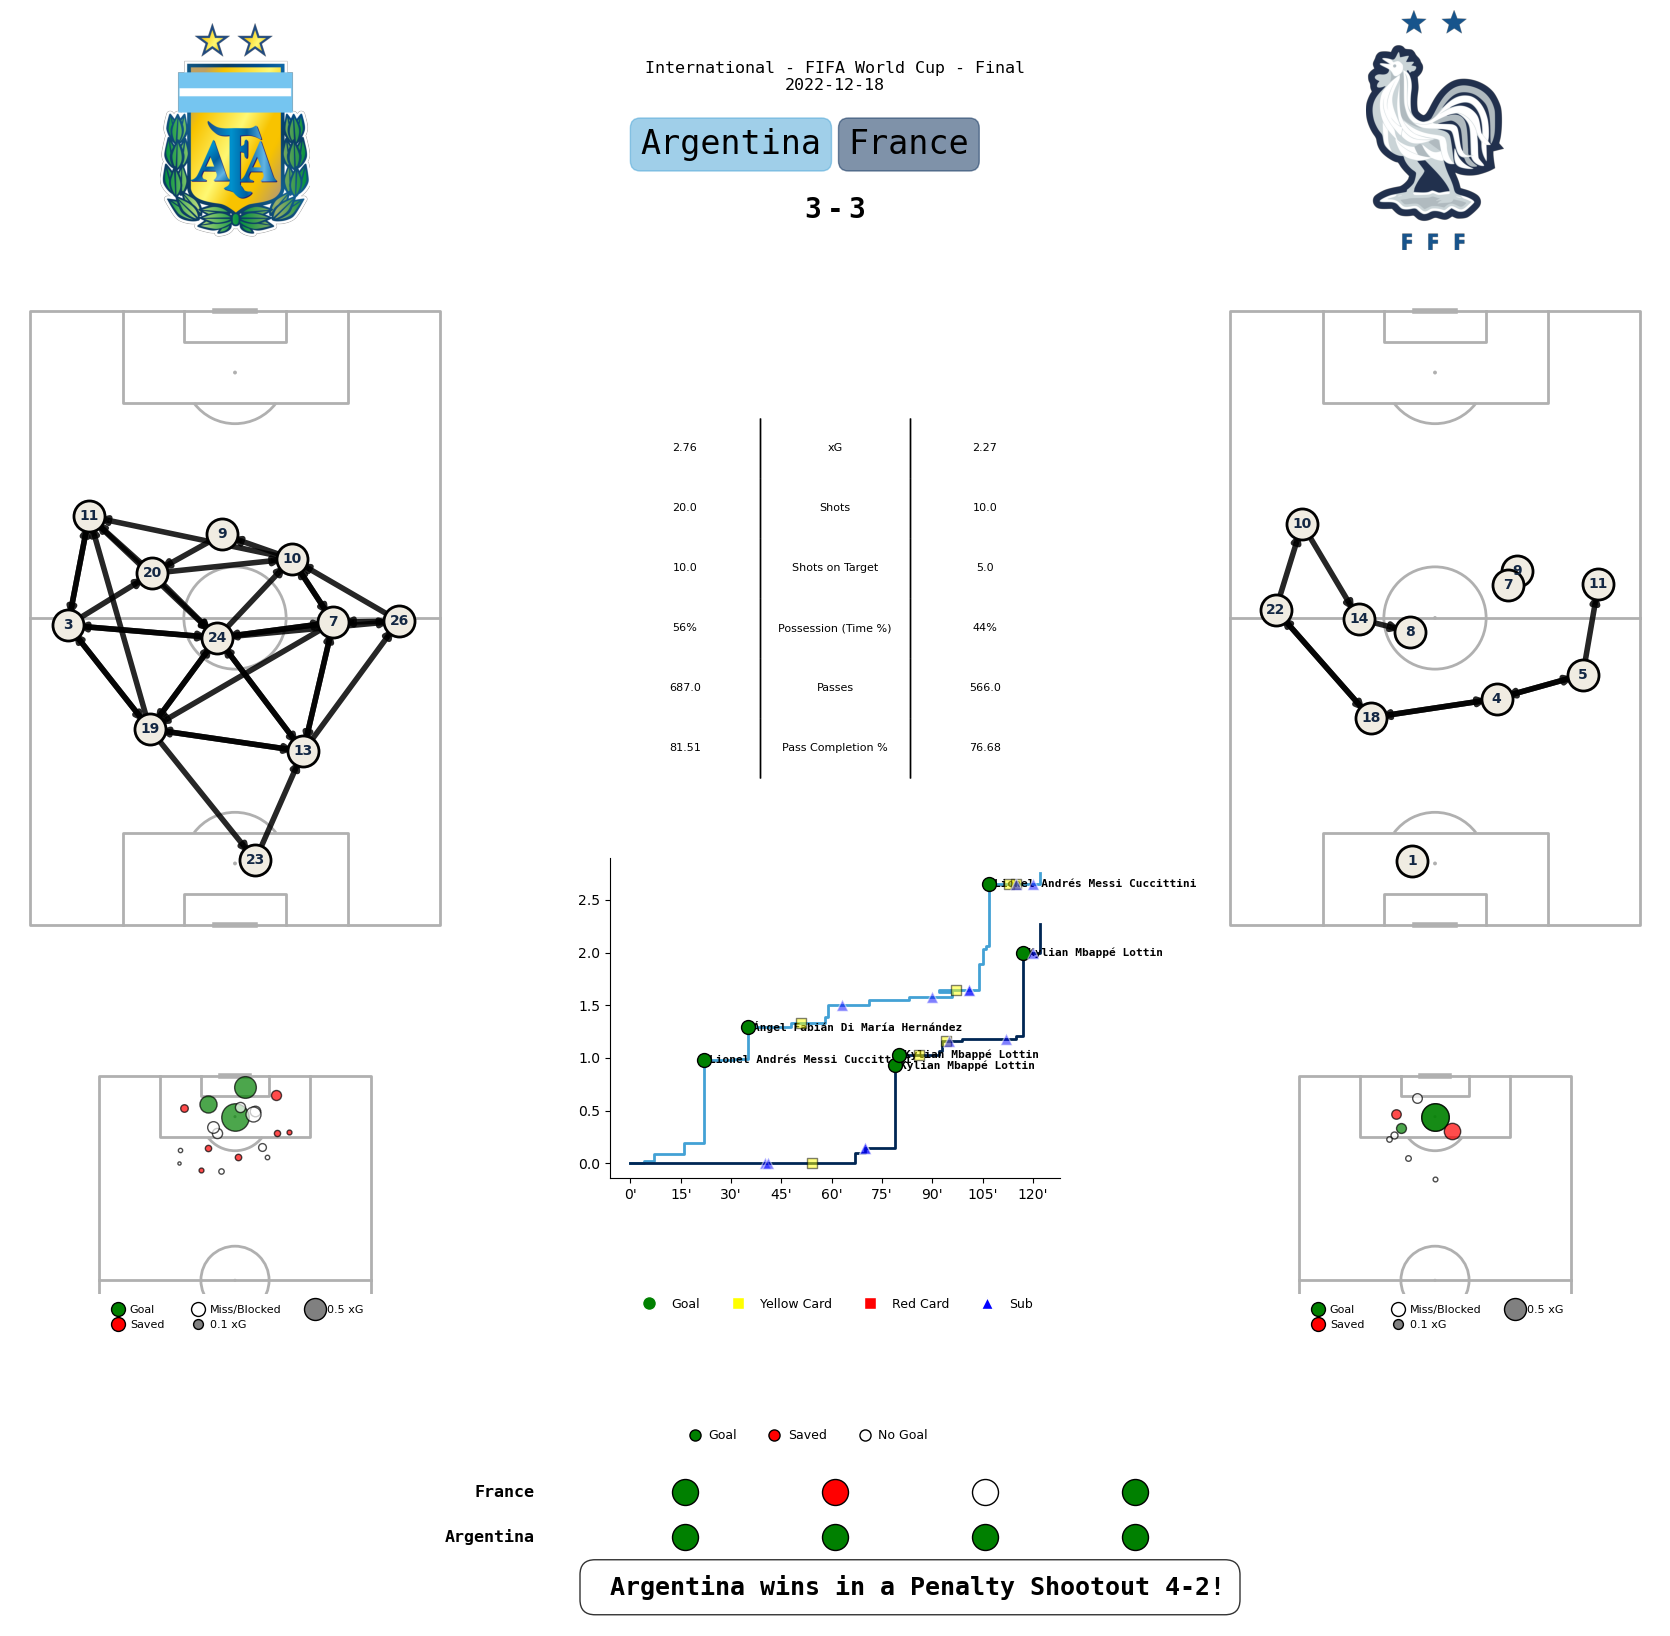

In [18]:
# --- Getting a match dashboard for Argentina vs. France to check the penalty shootout logic ---

world_cup_final_2022_dashboard = create_match_dashboard(match_id=3869685, team1_color='#43A1D5', team2_color='#002654', show_team_badges=True,
                               team1_image='/Users/oliverdaboo/Desktop/football_analytics_courses/complete_football_analytics/complete-football-analytics-main/team_logos/argentina_logo.png',
                               team2_image='/Users/oliverdaboo/Desktop/football_analytics_courses/complete_football_analytics/complete-football-analytics-main/team_logos/france_logo.png'
)                     

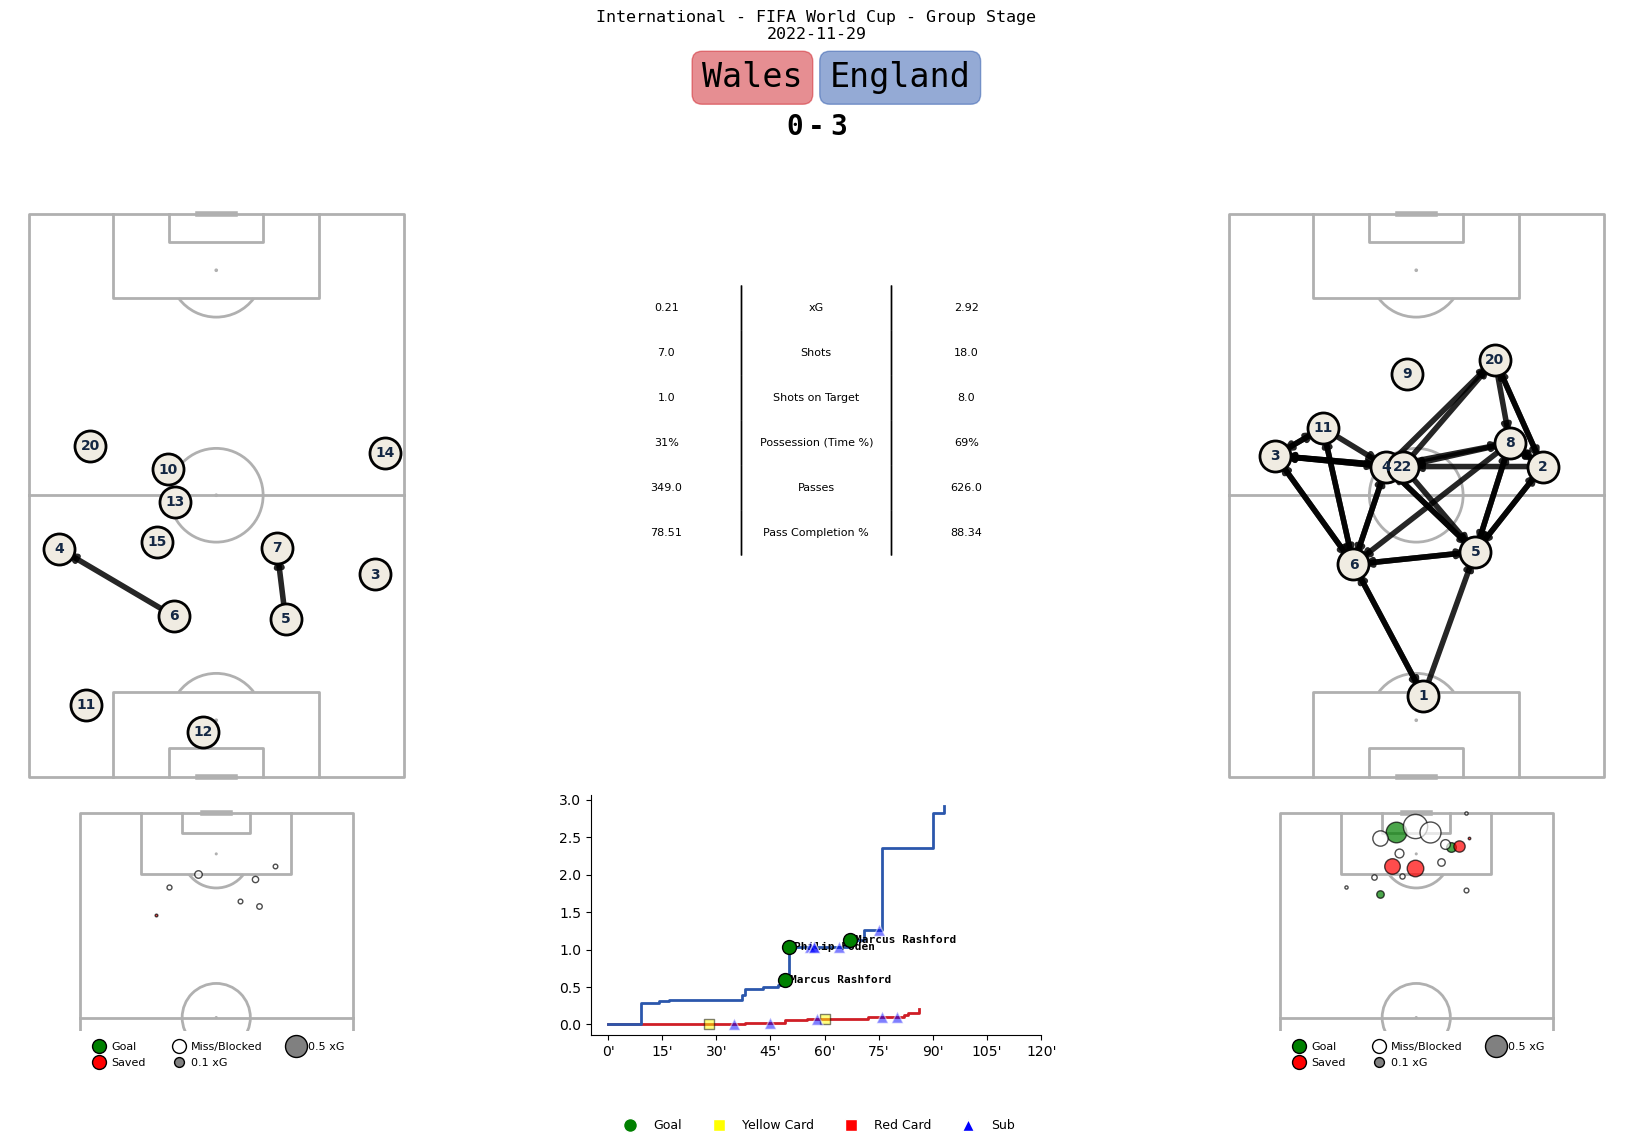

In [19]:
# --- Getting a match dashboard for England vs. Wales to check the non penalty shootout logic ---

wales_england_dashboard = create_match_dashboard(match_id = 3857261, team1_color='#CF1E26', 
                                team2_color='#2B57AC', show_team_badges=False)

In [20]:
# --- Getting a match dashboard for every single match during the 2022 World Cup ---

# Get the 2022 World Cup match list 
wc_2022_matches = sb.matches(competition_id=43, season_id=106)

# Loop through each row of the dataframe
for index, match in wc_2022_matches.iterrows():
    m_id = match['match_id']
    h_team = match['home_team']
    a_team = match['away_team']
    
    print(f"Generating dashboard for: {h_team} vs {a_team} (ID: {m_id})")

    # Generate the figure
    fig = create_match_dashboard(
        match_id=m_id,
        team1_color='#264653', 
        team2_color='#e9c46a', 
        match_info=match,
        show_team_badges=False
    )
    
    # Check if fig was created (in case ID was missing)
    if fig:
        # Construct a unique save path
        file_name = f"{h_team}_vs_{a_team}_{m_id}.png".replace(" ", "_")
        save_path = f'/Users/oliverdaboo/Desktop/football_analytics_courses/Match_Dashboard_Project/2022_WorldCup_Dashboards/{file_name}'

        # Save and close the figure to free up memory
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

Generating dashboard for: Serbia vs Switzerland (ID: 3857256)
Generating dashboard for: Argentina vs Australia (ID: 3869151)
Generating dashboard for: Australia vs Denmark (ID: 3857257)
Generating dashboard for: Brazil vs Serbia (ID: 3857258)


/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_95299/3323350054.py:382: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards['card_type'] = cards[available_cols[0]] if len(available_cols) == 1 else cards[available_cols[0]].fillna(cards[available_cols[1]])


Generating dashboard for: Tunisia vs Australia (ID: 3857288)
Generating dashboard for: Ecuador vs Senegal (ID: 3857267)
Generating dashboard for: Netherlands vs Argentina (ID: 3869321)
Generating dashboard for: Uruguay vs South Korea (ID: 3857287)
Generating dashboard for: Morocco vs Portugal (ID: 3869486)
Generating dashboard for: Argentina vs France (ID: 3869685)
Generating dashboard for: Saudi Arabia vs Mexico (ID: 3857260)
Generating dashboard for: Poland vs Argentina (ID: 3857264)
Generating dashboard for: France vs Denmark (ID: 3857266)
Generating dashboard for: Argentina vs Mexico (ID: 3857289)
Generating dashboard for: Brazil vs Switzerland (ID: 3857269)
Generating dashboard for: Netherlands vs Qatar (ID: 3857294)
Generating dashboard for: Portugal vs Switzerland (ID: 3869254)
Generating dashboard for: England vs Senegal (ID: 3869118)
Generating dashboard for: Croatia vs Morocco (ID: 3869684)
Generating dashboard for: Argentina vs Croatia (ID: 3869519)
Generating dashboard for:

/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_95299/3323350054.py:382: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards['card_type'] = cards[available_cols[0]] if len(available_cols) == 1 else cards[available_cols[0]].fillna(cards[available_cols[1]])


Generating dashboard for: South Korea vs Ghana (ID: 3857299)
Generating dashboard for: Portugal vs Ghana (ID: 3857298)
Generating dashboard for: Poland vs Saudi Arabia (ID: 3857297)
Generating dashboard for: Croatia vs Belgium (ID: 3857296)
Generating dashboard for: Ghana vs Uruguay (ID: 3857293)
Generating dashboard for: Costa Rica vs Germany (ID: 3857292)
Generating dashboard for: Spain vs Costa Rica (ID: 3857291)
Generating dashboard for: Switzerland vs Cameroon (ID: 3857290)
Generating dashboard for: Senegal vs Netherlands (ID: 3857285)
Generating dashboard for: Croatia vs Canada (ID: 3857281)
Generating dashboard for: Cameroon vs Brazil (ID: 3857280)
Generating dashboard for: France vs Australia (ID: 3857279)
Generating dashboard for: Iran vs United States (ID: 3857278)
Generating dashboard for: Morocco vs Croatia (ID: 3857277)
Generating dashboard for: Canada vs Morocco (ID: 3857276)
Generating dashboard for: Tunisia vs France (ID: 3857275)
Generating dashboard for: Netherlands v

/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_95299/3323350054.py:382: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards['card_type'] = cards[available_cols[0]] if len(available_cols) == 1 else cards[available_cols[0]].fillna(cards[available_cols[1]])


Generating dashboard for: Wales vs England (ID: 3857261)
Generating dashboard for: Japan vs Spain (ID: 3857255)
Generating dashboard for: Denmark vs Tunisia (ID: 3857254)
